In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from os import listdir
import cobra
from cobra.io import load_json_model, save_json_model, read_sbml_model
from cobra.medium import minimal_medium

In [2]:
import warnings
warnings.filterwarnings("ignore")
Agems = listdir('../data/A_GEMs/'); Bgems = listdir('../data/B_GEMs/');

In [3]:
model_status = []
for name in Agems+Bgems:
    if name[0]=='A':
        model = read_sbml_model('../data/A_GEMs/'+name)
    else:
        model = read_sbml_model('../data/B_GEMs/'+name)
    
    temp = {'GEM':name,'Boundary':len(model.boundary),'With GPR':0,'Gap fill':0,}
    for rxn in model.reactions-model.boundary:
        if rxn.gene_reaction_rule == '':
            temp['Gap fill'] +=1
        else:
            temp['With GPR'] +=1
    model_status.append(temp)
gem_status = pd.DataFrame(model_status)

In [4]:
gem_status['Sum'] = gem_status['Boundary']+gem_status['With GPR']+gem_status['Gap fill']
gem_status['Boundary(%)'] = gem_status['Boundary']*100/gem_status['Sum']
gem_status['With GPR(%)']= gem_status['With GPR']*100/gem_status['Sum']
gem_status['Gap fill(%)'] = gem_status['Gap fill']*100/gem_status['Sum']
gem_status['Group'] = ['A' for i in range(len(Agems))] + ['B' for i in range(len(Bgems))]

Text(0.5, 1.0, 'GEM reaction curation')

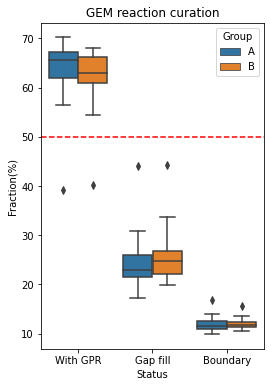

In [5]:
fig, ax = plt.subplots(1,1,figsize=(4,6))
temp_pd = pd.DataFrame(zip(list(gem_status['With GPR(%)'])+list(gem_status['Gap fill(%)'])+list(gem_status['Boundary(%)']),
                    list(gem_status['Group'])*3, 
                    ['With GPR' for i in range(len(gem_status.index))]+['Gap fill' for i in range(len(gem_status.index))]+\
                  ['Boundary' for i in range(len(gem_status.index))]), columns=['Fraction(%)','Group','Status'])
sns.boxplot(data=temp_pd,x='Status',y='Fraction(%)',hue='Group',ax=ax)
ax.axhline(y=50,color='red',linestyle='--')
ax.set_title('GEM reaction curation')

In [ ]:
# mini_meds = {}
# for name in Agems+Bgems:
#     if name[0]=='A':
#         model = read_sbml_model('../data/A_GEMs/'+name)
#     else:
#         model = read_sbml_model('../data/B_GEMs/'+name)
#     result = minimal_medium(model,0.01,minimize_components=True)
#     mini_meds[ name.replace('.xml','') ] = list( result.keys() )

In [ ]:
# all_mets = []
# for k in mini_meds:
#     all_mets += mini_meds[k]
# all_mets = list( set(all_mets) )
# data=[]
# for k in mini_meds:
#     temp = {met:0 for met in all_mets}; temp['bin_id'] = k
#     for met in mini_meds[k]:
#         temp[met] = 1
#     data.append(temp)
# minmeds = pd.DataFrame(data)
# minmeds = minmeds[['bin_id']+all_mets]
# for col in all_mets:
#     minmeds = minmeds.rename(columns={col:col.replace('EX_','').replace('_e','')})
# minmeds.to_csv('../data/metagenome/cobra_mini_med.csv',index=None)

In [6]:
Aclass = pd.read_csv('../data/metagenome/A_species.csv');
Bclass = pd.read_csv('../data/metagenome/B_species.csv');

In [7]:
minmeds = pd.read_csv('../data/metagenome/cobra_mini_med.csv')
keep_cols = ['bin_id', 'pro__L', 'fol', 'uri', 'hxan', 'ser__L','ump', 'pnto__R', 'thr__L', 'ura', 
       'trp__L', 'his__L', 'cmp', 'lys__L', 'tyr__L', 'glu__L', 'phe__L',
       'thm', 'leu__L', 'dcyt', 'ins','cys__L','amp', 'gly', 'ribflv', 'gmp', 'ala__L',
    'thymd', 'val__L', 'asp__L', 'gsn', 'nac', 'arg__L', 'adn', 'met__L', 'ile__L']
minmeds = minmeds[keep_cols]
minmeds = minmeds.set_index(['bin_id'])
minmeds = minmeds.T
A_cols = []; B_cols = [];
for bin_id in Aclass.bin_id:
    minmeds = minmeds.rename(columns={'A_'+bin_id:'A_'+bin_id+'_'\
                                            +list(Aclass[Aclass['bin_id']==bin_id]['genus'])[0] })
    A_cols.append( 'A_'+bin_id+'_'+list(Aclass[Aclass['bin_id']==bin_id]['genus'])[0])
for bin_id in Bclass.bin_id:
    minmeds = minmeds.rename(columns={'B_'+bin_id:'B_'+bin_id\
                                            +'_'+list(Bclass[Bclass['bin_id']==bin_id]['genus'])[0] })
    B_cols.append('B_'+bin_id+'_'+list(Bclass[Bclass['bin_id']==bin_id]['genus'])[0])
A_minmeds = minmeds[A_cols]; B_minmeds = minmeds[B_cols]

In [8]:
nus = ['uri','adn', 'amp','hxan','gmp','ump','ura','gsn','dcyt','ins', 'cmp','thymd'];
vitas=['fol','nac','ribflv','pnto__R','thm'];
aas = []; others=[]; 
for met in minmeds.index:
    if ('__L' in met) or met =='gly':
        aas.append(met)

In [9]:
genus_colors = {'Streptococcus':'tab:orange','Prevotella':'tab:red','Alloprevotella':'tab:red',
               'Haemophilus':'tab:blue','Neisseria':'tab:purple','Porphyromonas':'tab:olive','Veillonella':'tab:brown'}

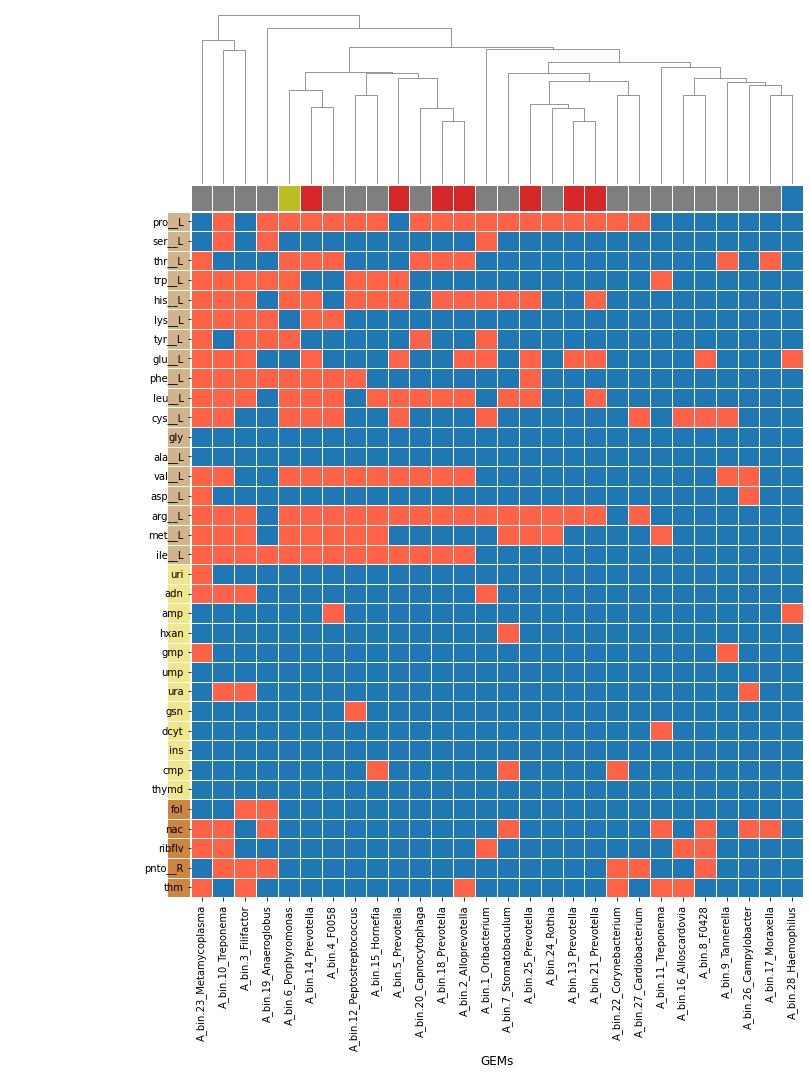

In [10]:
A_minmeds = A_minmeds.reindex(aas+nus+vitas)
row_colors=[];col_colors=[];
for met in A_minmeds.index:
    if met in aas:
        row_colors.append('tan')
    elif met in nus:
        row_colors.append('khaki')
    elif met in vitas:
        row_colors.append('peru')
for mag in A_minmeds.columns:
    if mag.split('_')[-1] not in genus_colors.keys():
        col_colors.append('tab:gray')
    else:
        col_colors.append( genus_colors[mag.split('_')[-1]])
        
fg=sns.clustermap(A_minmeds, row_cluster=False,figsize=(12,15),cmap =['tab:blue', 'tomato'],cbar_kws={'ticks':[0,1.0]},
               row_colors=row_colors,col_colors=col_colors, linecolor='white',linewidths=1, cbar_pos=None)
fg.ax_heatmap.set_xlabel('GEMs',fontsize=12)
fg.ax_heatmap.axes.yaxis.set_ticks_position('left')
# plt.savefig('../../../../Oral_paper/Figures_2025/A_minmeds.svg',format='svg',dpi=150)

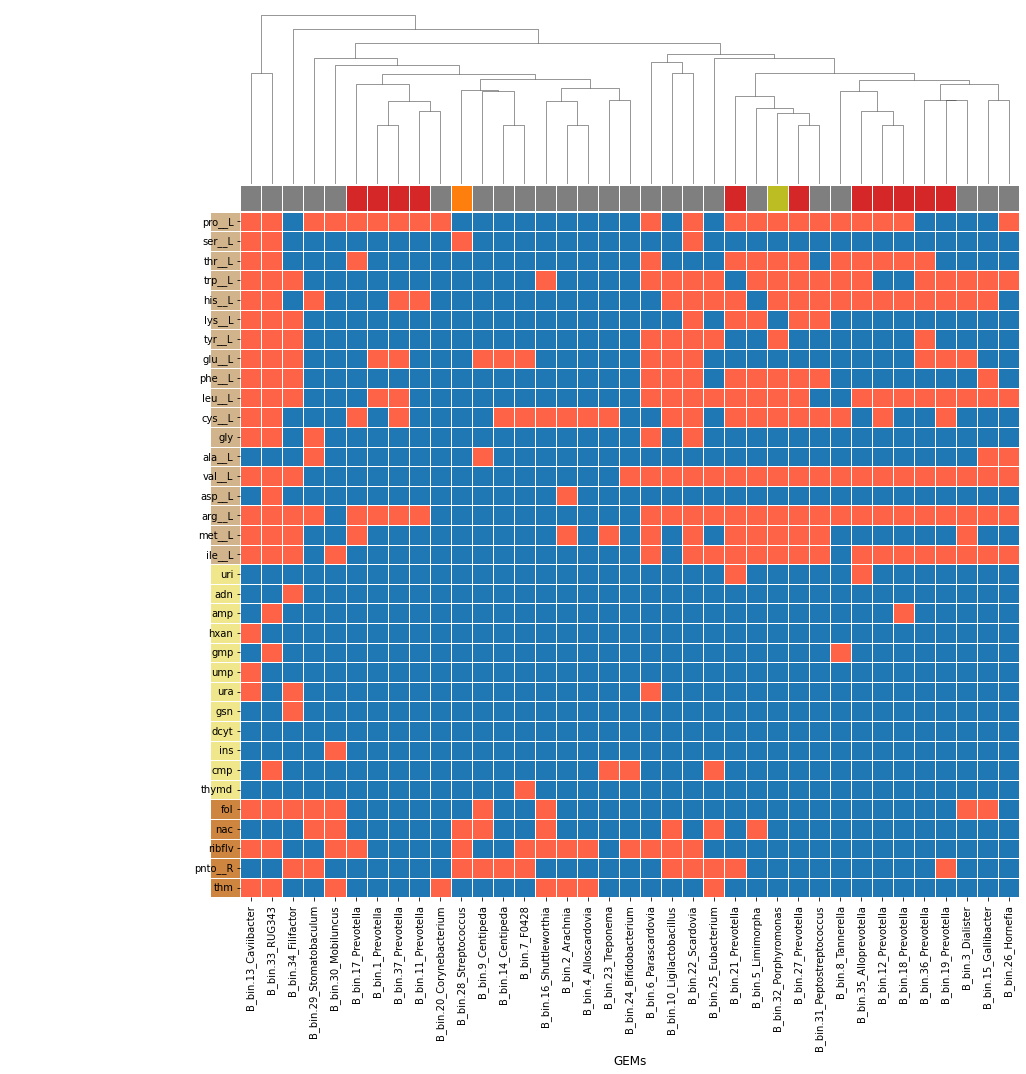

In [11]:
B_minmeds = B_minmeds.reindex(aas+nus+vitas)
row_colors=[]; col_colors=[];
for met in B_minmeds.index:
    if met in aas:
        row_colors.append('tan')
    elif met in nus:
        row_colors.append('khaki')
    elif met in vitas:
        row_colors.append('peru')
for mag in B_minmeds.columns:
    if mag.split('_')[-1] not in genus_colors.keys():
        col_colors.append('tab:gray')
    else:
        col_colors.append( genus_colors[mag.split('_')[-1]])
fg=sns.clustermap(B_minmeds, row_cluster=False,figsize=(15,15),cmap =['tab:blue', 'tomato'],cbar_kws={'ticks':[0,1.0]},
               row_colors=row_colors,col_colors=col_colors, linecolor='white',linewidths=1, cbar_pos=None)
fg.ax_heatmap.set_xlabel('GEMs',fontsize=12)
fg.ax_heatmap.axes.yaxis.set_ticks_position('left')
# plt.savefig('../../../../Oral_paper/Figures_2025/B_minmeds.svg',format='svg',dpi=150)